In [1]:
import os, sys, glob, json, csv, time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm import tqdm

# Make sure the project root and config module are found.
# If config.py is in the src/ folder, add that to sys.path.
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.insert(0, src_path)

# Import configuration variables.
from config import (
    PROJECT_ROOT, RAW_DIR, PROCESSED_FEATURES_DIR, AUDIO_EXTENSIONS,
    TEMPO_MODEL_FILE, EMB_DISCOGS_MODEL_FILE, EMB_MSD_MODEL_FILE,
    GENRE_MODEL_FILE, VOICE_MODEL_FILE, DANCEABILITY_MODEL_FILE,
    EMOTION_MODEL_FILE, TEMPO_METHOD, EMB_DISCOGS_MODEL_JSON
)

# Set plotting style
sns.set(style="whitegrid")
%matplotlib inline

print("Project Root:", PROJECT_ROOT)
print("Processed Features Directory:", PROCESSED_FEATURES_DIR)

Project Root: /home/cepatinog/amplab
Processed Features Directory: /home/cepatinog/amplab/data/processed/features


In [2]:
# Path to the Discogs-Effnet metadata file (adjust if located in a different folder)
discogs_metadata_file = EMB_DISCOGS_MODEL_JSON

processed_features_dir = PROCESSED_FEATURES_DIR

# %% [code] Load the Discogs-Effnet Model Metadata and Extract Genre Classes
with open(discogs_metadata_file, "r") as f:
    discogs_metadata = json.load(f)

# Extract the full list of 400 genre classes
genre_classes = discogs_metadata.get("classes", [])
print(f"Loaded {len(genre_classes)} genre classes from discogs-effnet-bs64-1.json.")


Loaded 400 genre classes from discogs-effnet-bs64-1.json.


First 10 genre classes:
Blues---Boogie Woogie
Blues---Chicago Blues
Blues---Country Blues
Blues---Delta Blues
Blues---Electric Blues
Blues---Harmonica Blues
Blues---Jump Blues
Blues---Louisiana Blues
Blues---Modern Electric Blues
Blues---Piano Blues
Found 2100 processed feature files.
DataFrame shape: (2100, 24)
Sample predictions:
                                                file  \
0  /home/cepatinog/amplab/data/raw/audio_chunks/a...   
1  /home/cepatinog/amplab/data/raw/audio_chunks/a...   
2  /home/cepatinog/amplab/data/raw/audio_chunks/a...   
3  /home/cepatinog/amplab/data/raw/audio_chunks/a...   
4  /home/cepatinog/amplab/data/raw/audio_chunks/a...   

               predicted_genre parent_genre  
0   Hip Hop---Hardcore Hip-Hop      Hip Hop  
1       Electronic---Downtempo   Electronic  
2       Electronic---Synth-pop   Electronic  
3          Hip Hop---Cloud Rap      Hip Hop  
4  Electronic---Tropical House   Electronic  


/tmp/ipykernel_5989/3996108133.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y="parent_genre", data=df, order=order, palette="viridis")


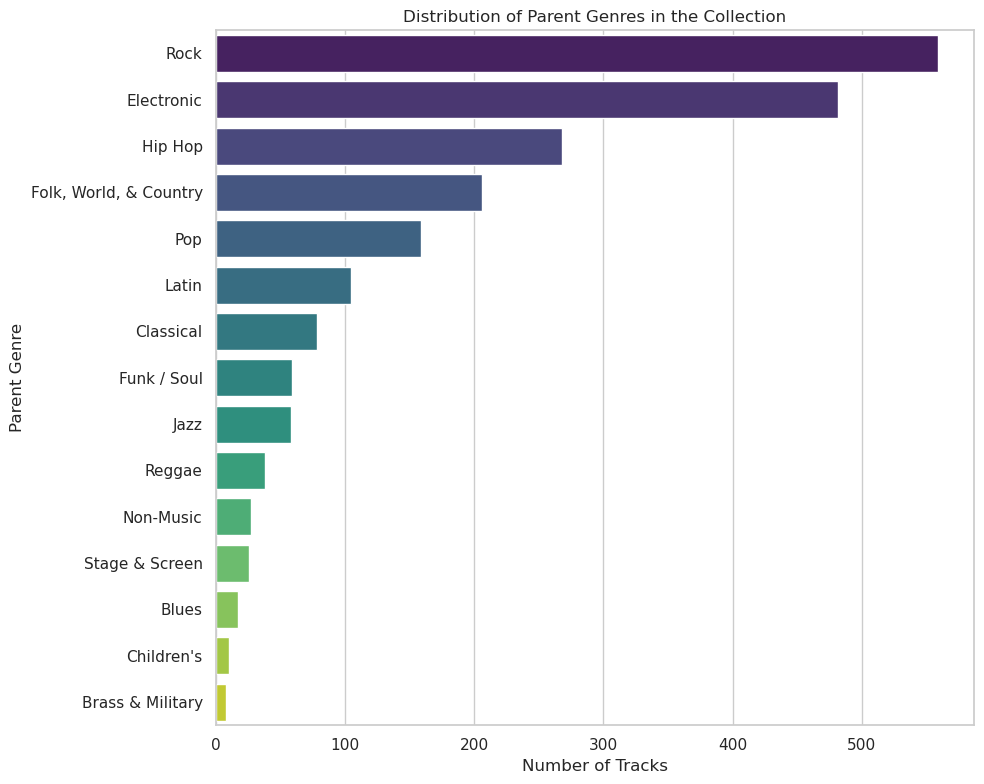

Genre predictions saved to: /home/cepatinog/amplab/data/processed/features/genre_predictions.tsv


In [3]:
# For inspection, print the first 10 classes:
print("First 10 genre classes:")
for genre in genre_classes[:10]:
    print(genre)

# Load Processed Feature Files
# Get all JSON files in the processed features folder.
feature_files = glob.glob(os.path.join(processed_features_dir, "*.json"))
print(f"Found {len(feature_files)} processed feature files.")

# Load each JSON file into a list.
data = []
for file in feature_files:
    try:
        with open(file, "r") as f:
            feat = json.load(f)
            data.append(feat)
    except Exception as e:
        print(f"Error reading {file}: {e}")

# Create a DataFrame from the loaded data.
df = pd.DataFrame(data)
print("DataFrame shape:", df.shape)
df.head()

# %% [code] Compute Final Genre Predictions
def predict_genre(activation_vector, classes):
    """
    Given a 400-dimensional activation vector from the genre classifier,
    return the predicted genre label by taking the index with maximum activation.
    """
    idx = int(np.argmax(activation_vector))
    return classes[idx]

# Create a new column with the predicted genre (using single-label max strategy).
# We assume that each processed feature JSON has a "genre_activations" field.
df["predicted_genre"] = df["genre_activations"].apply(lambda acts: predict_genre(acts, genre_classes))

# Extract the parent genre from the predicted genre label.
# We assume that the genre labels follow the format "Parent---Style".
df["parent_genre"] = df["predicted_genre"].apply(lambda x: x.split("---")[0].strip())

print("Sample predictions:")
print(df[["file", "predicted_genre", "parent_genre"]].head())

# %% [code] Plot the Distribution of Parent Genres
plt.figure(figsize=(10, 8))
order = df["parent_genre"].value_counts().index
sns.countplot(y="parent_genre", data=df, order=order, palette="viridis")
plt.title("Distribution of Parent Genres in the Collection")
plt.xlabel("Number of Tracks")
plt.ylabel("Parent Genre")
plt.tight_layout()
plt.show()

# %% [code] Save Full Genre Predictions to a TSV File
output_tsv = os.path.join(processed_features_dir, "genre_predictions.tsv")
df[["file", "predicted_genre", "parent_genre"]].to_csv(output_tsv, sep="\t", index=False)
print("Genre predictions saved to:", output_tsv)

### Tempo and Danceability Distribution
We now plot the distribution of tempo and danceability. (For danceability, we use the signal-based measure stored under "danceability_signal".

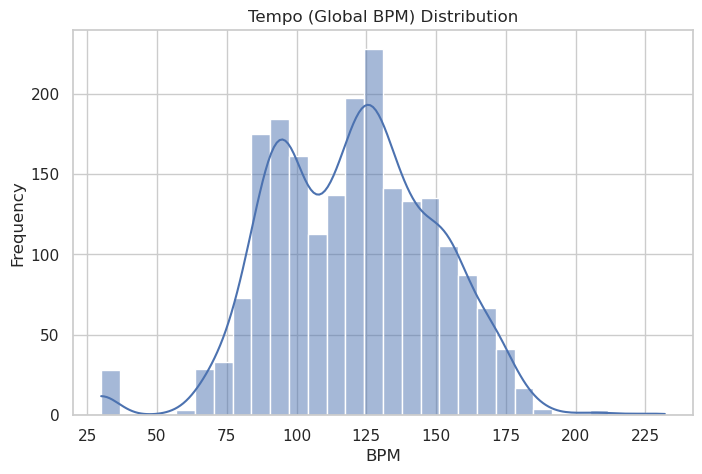

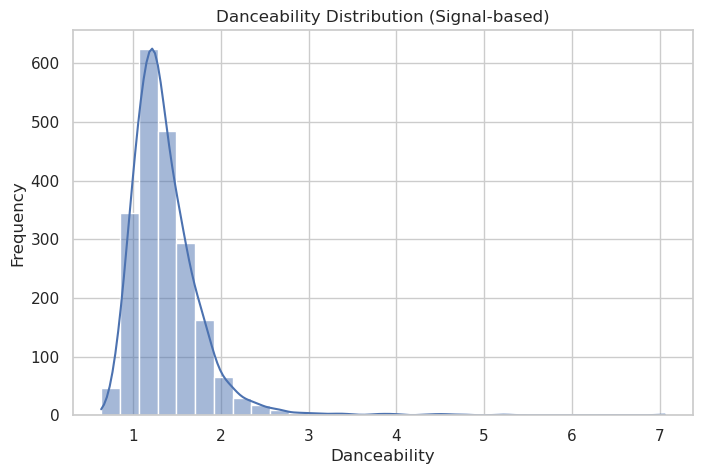

In [4]:
# Tempo: global BPM
plt.figure(figsize=(8,5))
sns.histplot(df['tempo_global_bpm'].dropna(), bins=30, kde=True)
plt.title("Tempo (Global BPM) Distribution")
plt.xlabel("BPM")
plt.ylabel("Frequency")
plt.show()

# Danceability: extract the numeric value from "danceability_signal" (a dict)
df['danceability'] = df['danceability_signal'].apply(lambda x: x.get("danceability") if isinstance(x, dict) else np.nan)

plt.figure(figsize=(8,5))
sns.histplot(df['danceability'].dropna(), bins=30, kde=True)
plt.title("Danceability Distribution (Signal-based)")
plt.xlabel("Danceability")
plt.ylabel("Frequency")
plt.show()


## Keys and Scales
We have key estimates from three profiles: "temperley_key", "krumhansl_key", and "edma_key" (and similarly for scales). We plot the distributions and also compute the percentage of tracks where all three agree.

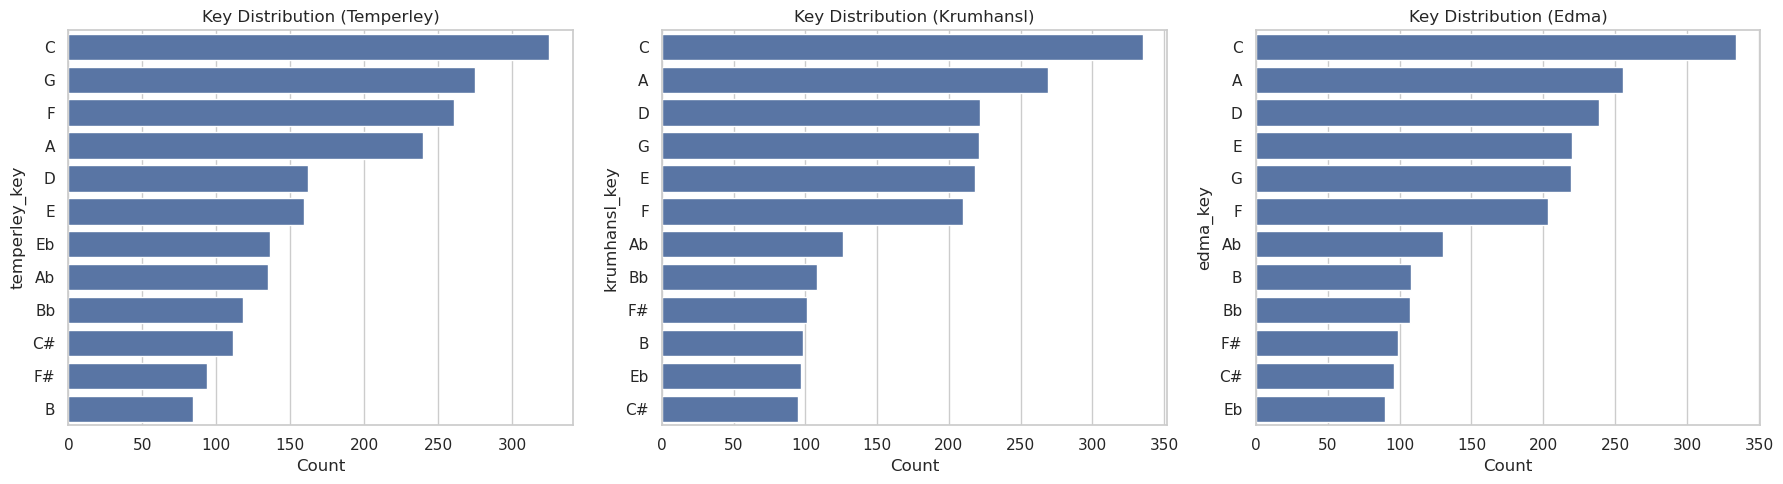

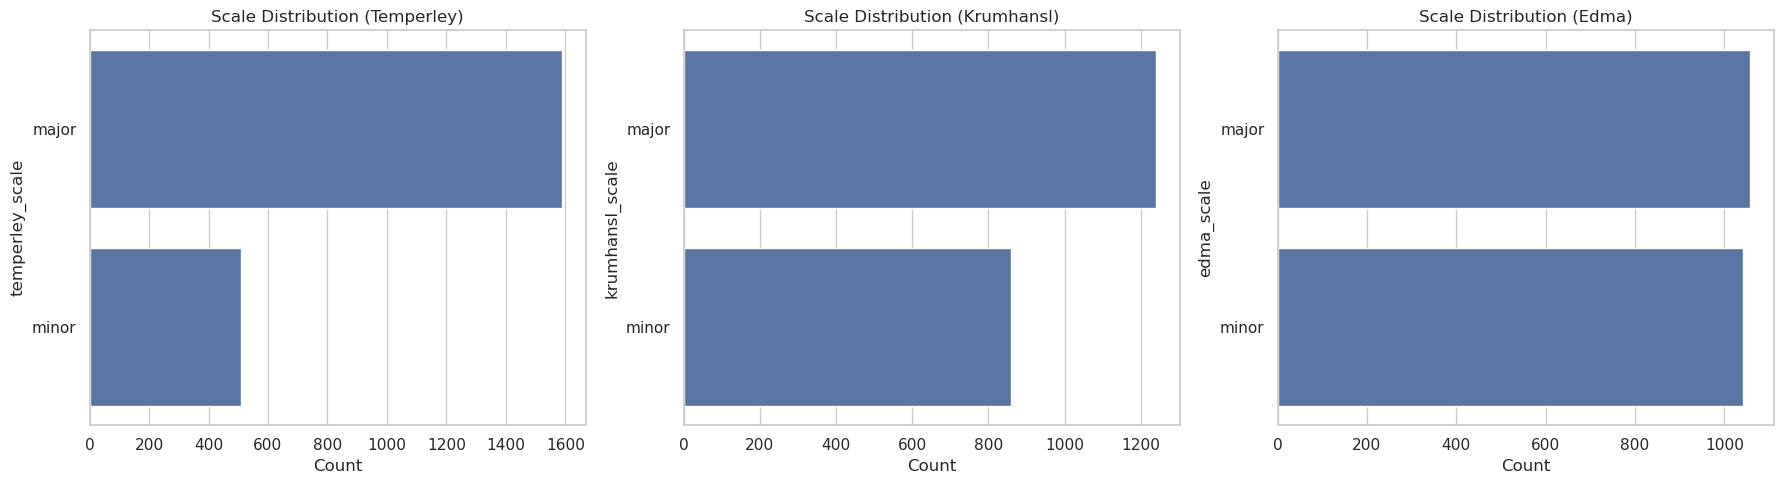

Percentage of tracks where all three key estimations agree: 53.19%


In [5]:
profiles = ['temperley', 'krumhansl', 'edma']
key_cols = [f"{p}_key" for p in profiles]
scale_cols = [f"{p}_scale" for p in profiles]

# Plot key distribution for each profile.
fig, axes = plt.subplots(1, 3, figsize=(18,5))
for ax, col in zip(axes, key_cols):
    sns.countplot(y=col, data=df, order=df[col].value_counts().index, ax=ax)
    ax.set_title(f"Key Distribution ({col.split('_')[0].capitalize()})")
    ax.set_xlabel("Count")
plt.tight_layout()
plt.show()

# Plot scale distribution for each profile.
fig, axes = plt.subplots(1, 3, figsize=(18,5))
for ax, col in zip(axes, scale_cols):
    sns.countplot(y=col, data=df, order=df[col].value_counts().index, ax=ax)
    ax.set_title(f"Scale Distribution ({col.split('_')[0].capitalize()})")
    ax.set_xlabel("Count")
plt.tight_layout()
plt.show()

# Calculate % of tracks where all three key estimations agree.
def all_keys_agree(row):
    return len(set(row[key_cols])) == 1

df['keys_agree'] = df.apply(all_keys_agree, axis=1)
agreement_percent = df['keys_agree'].mean() * 100
print(f"Percentage of tracks where all three key estimations agree: {agreement_percent:.2f}%")


### Loudness Distribution
We plot the integrated loudness (in LUFS).

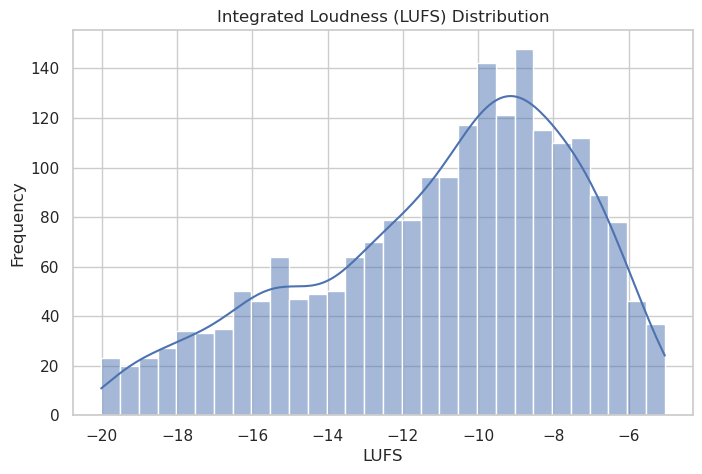

In [6]:
# %% [code]
plt.figure(figsize=(8,5))
sns.histplot(df['loudness_integrated_loudness'].dropna(), bins=30, kde=True)
plt.title("Integrated Loudness (LUFS) Distribution")
plt.xlabel("LUFS")
plt.ylabel("Frequency")
plt.show()

### Arousal/Valence Emotion Space
We extract the arousal and valence values from the "arousal_valence" dictionary and create a 2D scatter plot.

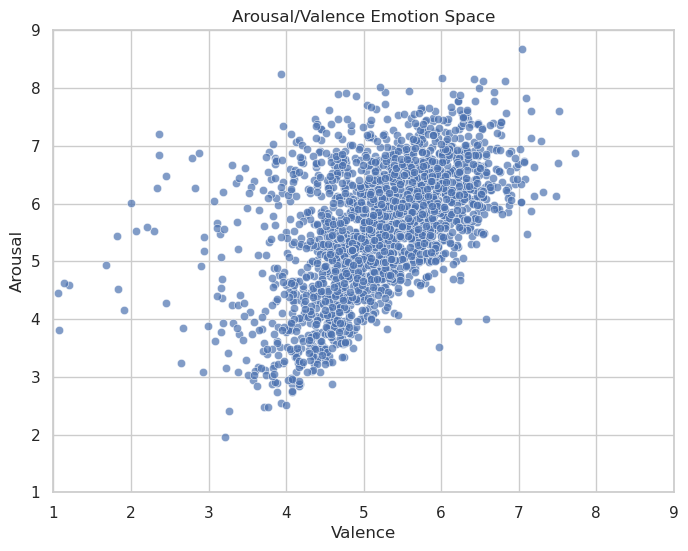

In [7]:
# Create separate columns for arousal and valence.
df['valence'] = df['arousal_valence'].apply(lambda x: x.get("valence") if isinstance(x, dict) else np.nan)
df['arousal'] = df['arousal_valence'].apply(lambda x: x.get("arousal") if isinstance(x, dict) else np.nan)

plt.figure(figsize=(8,6))
sns.scatterplot(x='valence', y='arousal', data=df, alpha=0.7)
plt.title("Arousal/Valence Emotion Space")
plt.xlabel("Valence")
plt.ylabel("Arousal")
plt.xlim(1,9)
plt.ylim(1,9)
plt.show()

## Vocal vs Instrumental
Count the number of tracks predicted as vocal vs instrumental using the "voice_instrumental" field.

Vocal vs Instrumental counts:
voice_instrumental_class
voice           1499
instrumental     601
Name: count, dtype: int64


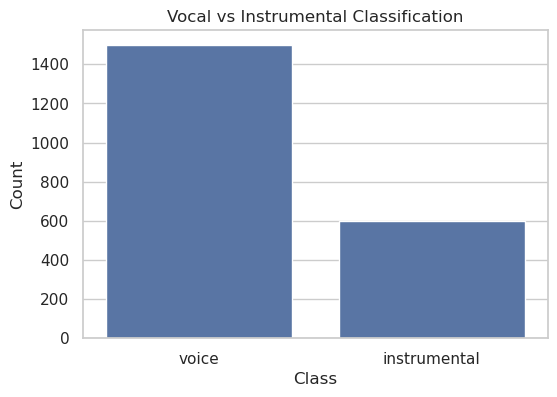

In [8]:
# Extract predicted class from the voice/instrumental field.
df['voice_instrumental_class'] = df['voice_instrumental'].apply(lambda x: x.get("predicted_class") if isinstance(x, dict) else np.nan)
vi_counts = df['voice_instrumental_class'].value_counts()
print("Vocal vs Instrumental counts:")
print(vi_counts)

plt.figure(figsize=(6,4))
sns.countplot(x='voice_instrumental_class', data=df, order=vi_counts.index)
plt.title("Vocal vs Instrumental Classification")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

